In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import xarray as xr
import time
import seaborn as sns
from itertools import product
from scipy.interpolate import interp2d
import json
from glob import glob
import scipy.stats

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
from sklearn.gaussian_process import GaussianProcessRegressor 
from scipy.interpolate import griddata
from bayes_opt.util import load_logs

In [2]:
def rvalue(obs, mod):
    nanmask = np.isfinite(obs)
    y = obs[nanmask]
    x = mod[nanmask]
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value

def calcLCE(obs, mod):
    r = rvalue(obs, mod)
    alpha = np.nanstd(mod)/np.nanstd(obs)
    beta = np.nanmean(mod)/np.nanmean(obs)
    return 1 -np.sqrt(((r*alpha - 1)**2) + ((r/alpha - 1)**2) + (beta - 1)**2)

def calcCompoundLCE(observedWTE, modelWTE, observedQ, modelQ, observedET, modelET):
    wteLCE = calcLCE(observedWTE, modelWTE)
    qLCE = calcLCE(observedQ, modelQ)
    etLCE = calcLCE(observedET, modelET)

    #Could replace later with different weights
    return np.mean([wteLCE, qLCE, etLCE])
    
def blackbox_clm(grass_scalar, tree_scalar): #grass_scalar, tree_scalar
    #change parameter in netcdf file
    target_surface_file = '/glade/u/home/marielj/cesm-hillslope/calib-surf-files/surfdata_1x1pt_US-MBP_hist_16pfts_Irrig_CMIP6_simyr2000_HAND_3_col_hillslope_lagg_pftdist_soildepth.nc'
    target_param_file = '/glade/u/home/marielj/cesm-hillslope/calib-surf-files/clm50_params_2D_bayesopt.c240105.nc'
    
    target_param1 = 'grass_scalar'
    target_param2 = 'tree_scalar'
    base_grass_ms = 5.25
    base_conif_ms = 2.3499999
    base_decid_ms = 4.44999981

    #change grass parameters 
    change_pft_param(target_param1*base_grass_ms, medlynslope, 13, target_param_file)

    #change tree parameters
    change_pft_param(target_param2*base_conif_ms, medlynslope, 2, target_param_file) #conif
    change_pft_param(target_param2*base_decid_ms, medlynslope, 8, target_param_file) #decid
    
    os.chdir(CASE_DIR)

    #run case
    pipe = subprocess.Popen(['./case.submit'], stdout=subprocess.PIPE)
    #result = pipe.communicate()[0]
    #print(result)
    #print(CASE_NAME + " Run Complete")
    
    #time delay -- check if archived data exists, if not wait 5 more seconds
    #Have to check for the column specific run here for proper bog wte calibration
    SCRATCH_DIR = '/glade/derecho/scratch/marielj/archive/' + CASE_NAME + '/lnd/hist/'
    while(not os.path.exists(SCRATCH_DIR + CASE_NAME + '.clm2.h3.2015-01-01-00000.nc')):
        time.sleep(5)
    
    #find WTE data in scracth directory
    os.chdir(SCRATCH_DIR)
    
    #Open data h1 and h3 data files
    coldata = xr.load_dataset(CASE_NAME + '.clm2.h3.2015-01-01-00000.nc')
    data = xr.load_dataset(CASE_NAME + '.clm2.h1.2015-01-01-00000.nc')
    
    #Compute correlation metric
    observedWTE = np.array(wte_calib.WTD)
    modelWTE = -np.array(coldata.sel(column = 1).sel(time = slice("2015-01-01", "2015-12-31")).ZWT.values)
    observedQ = np.array(stream_calib.flow_mmday)
    modelQ = spday*np.array(data.sel(time = slice("2015-01-01", "2015-12-31")).QRUNOFF.values.ravel())
    observedET = np.array(flux_calib.OET)
    modelET = spday*np.array(data.sel(time = slice("2015-01-01", "2015-12-31")).ET.values.ravel())
    #Compound Lee Choi Efficiency
    LCE = calcCompoundLCE(observedWTE, modelWTE, observedQ, modelQ, observedET, modelET)
    
    #remove data
    os.remove(CASE_NAME + '.clm2.h3.2015-01-01-00000.nc')
    os.remove(CASE_NAME + '.clm2.h1.2015-01-01-00000.nc')
    
    #return efficiency metric
    return LCE

#Optimizer
clm_optimizer = BayesianOptimization(f = blackbox_clm, 
                                     #pbounds = {'grass_scalar' : (1, 10), 'tree_scalar' : (1, 10)}, 
                                    pbounds = {'tree_scalar' : (1, 20), 'grass_scalar' : (1, 20)}, 
                                    random_state = 75832, 
                                    verbose = 0
                                    )

#Acquisition Function
acquisition_function = UtilityFunction(kind = "ucb", kappa = 0.1)

In [3]:
def plot_gp_2D(optimizer, aq, it, param1, param2, param1_min, param1_max, param2_min, param2_max):
    #Setup 
    #Breakdown Data
    max_ = optimizer.max
    res = optimizer.res[:it]
    x_ = np.array([r["params"][param1] for r in res])
    y_ = np.array([r["params"][param2] for r in res])
    z_ = np.array([r["target"] for r in res])
    points = pd.DataFrame({'grass_scalar' : x_,
              'tree_scalar': y_})

    #Model Results
    ser = pd.Series(z_,
                      index=[y_, x_])
    Z = ser.unstack().fillna(np.nan)

    #Range space
    x1 = np.linspace(param1_min, param1_max, 100).reshape(-1, 1)
    x2 = np.linspace(param2_min, param2_max, 100).reshape(-1, 1)
    xmesh, ymesh = np.meshgrid(x1, x2)
    xy = np.array(list(zip(xmesh.reshape(10000, 1), ymesh.reshape(10000, 1)))).reshape(10000,2)

    #Utility Function
    util = aq.utility(xy, optimizer._gp, 0)
    
    #Plot
    fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(6,6))

    #Axis 1: Function Estimate
    grid_z0 = griddata(points, z_, xy, method='nearest').reshape(100,100)
    mesh1 = axs.pcolormesh(xmesh, ymesh,  grid_z0, cmap=plt.cm.coolwarm)
    axs.scatter(x_, y_, c='white', s=80, edgecolors='black')
    axs.scatter(x_, y_, c='red', s=80, edgecolors='black')
    axs.scatter(max_["params"][param1], max_["params"][param2], s=80, c='yellow', edgecolors='black')

    axs.set_title('Function Estimate')
    axs.set_xlabel(param1)
    axs.set_ylabel(param2)

    axs.set_xlim(param1_min, param1_max)
    axs.set_ylim(param2_min, param2_max)

    fig.colorbar(mesh1, location = 'bottom', label = r"Lee Choi Efficiency")

    plt.show()

In [4]:
load_logs(clm_optimizer, logs=["/glade/u/home/marielj/cesm-hillslope/logs/hillslope_logs_2D_medlynslope.json"])
print("New optimizer is now aware of {} points.".format(len(clm_optimizer.space)))

New optimizer is now aware of 70 points.


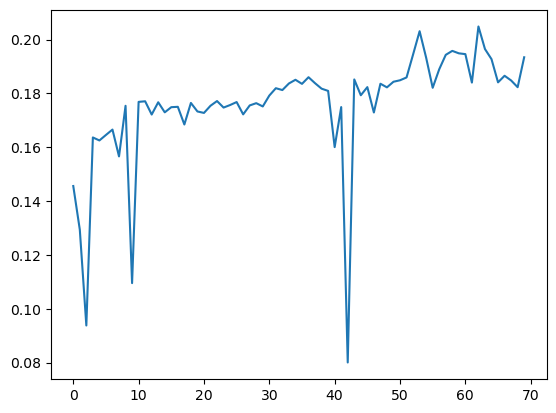

In [5]:
targ = []
for i, res in enumerate(clm_optimizer.res):
    #print("Iteration {}: \n\t{}".format(i, res))
    targ.append(res['target'])

plt.plot(targ)

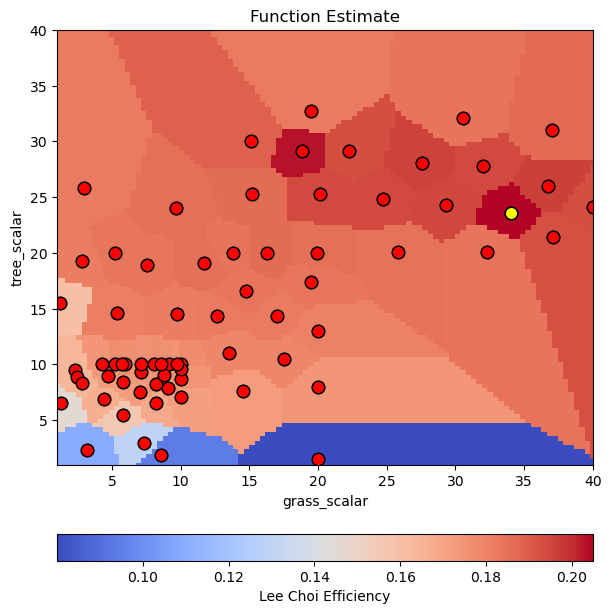

In [6]:
plot_gp_2D(clm_optimizer, acquisition_function, 70, 'grass_scalar', 'tree_scalar', 1, 40, 1, 40)

Timeseries comparison

In [29]:
flux.groupby([flux.time.dt.time, flux.time.dt.day, flux.time.dt.month]).mean()

/glade/derecho/scratch/marielj/tmp/ipykernel_250718/247904240.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  flux.groupby([flux.time.dt.time, flux.time.dt.day, flux.time.dt.month]).mean()


USTAR          H         LE             P  \
time     time time                                                 
00:15:00 1    1     0.150735  -8.918259   2.129472  9.969210e+36   
              2     0.177535 -16.947111   0.058747  9.969210e+36   
              3     0.127464 -14.555375   1.846993  9.969210e+36   
              4     0.132298 -18.611799   6.052058  9.969210e+36   
              5     0.191332 -19.151731  27.045980  9.969210e+36   
...                      ...        ...        ...           ...   
23:45:00 31   5     0.139518 -25.601124  33.464188  9.969210e+36   
              7     0.144408 -14.091411        NaN  9.969210e+36   
              8     0.104511 -27.324278  12.237132  9.969210e+36   
              10    0.141477 -14.458341   6.276801  9.969210e+36   
              12    0.133764 -10.584053  -0.701114  9.969210e+36   

                          NETRAD   SW_IN      LW_OUT          TS_1  \
time     time time                                                   
00:15:00 1    1     9.969210e+36 -1.6610  299.778656  9.969210e+36   
              2     9.969210e+36 -0.3580  195.497574  9.969210e+36   
              3     9.969210e+36 -0.8350  291.236023  9.969210e+36   
              4     9.969210e+36 -2.4760  289.497986  9.969210e+36   
              5     9.969210e+36 -1.6280  331.744629  9.969210e+36   
...                          ...     ...         ...           ...   
23:45:00 31   5     9.969210e+36 -1.3470  411.709015  9.969210e+36   
              7     9.969210e+36  0.5235  375.178528  9.969210e+36   
              8     9.969210e+36 -0.7265  404.002808  9.969210e+36   
              10    9.969210e+36 -1.7860  259.755554  9.969210e+36   
              12    9.969210e+36 -0.0325  280.503601  9.969210e+36   

                            TS_2       OET  
time     time time                          
00:15:00 1    1     9.969210e+36  0.001533  
              2     9.969210e+36  0.000042  
              3     9.969210e+36  0.001330  
              4     9.969210e+36  0.004357  
              5     9.969210e+36  0.019473  
...                          ...       ...  
23:45:00 31   5     9.969210e+36  0.024094  
              7     9.969210e+36       NaN  
              8     9.969210e+36  0.008811  
              10    9.969210e+36  0.004519  
              12    9.969210e+36 -0.000505  

[17568 rows x 10 columns]

In [49]:
'''Load calibration WTE data'''
calib_year = 2017
infile1  ="https://pasta.lternet.edu/package/data/eml/edi/562/2/671f15337a677da71852de506a8d9b05".strip() 
infile1  = infile1.replace("https://","http://")
                 
dt1 =pd.read_csv(infile1, skiprows = 1, sep = ",",
                 names=["PEATLAND", "DATE", "WTE", "FLAG"],
                 parse_dates=['DATE'], 
                 na_values={'WTE':['NA',], 'FLAG':['NA',]})

# Coerce the data into the types specified in theA metadata  
dt1.PEATLAND = dt1.PEATLAND.astype('category') 

dt1.WTE = pd.to_numeric(dt1.WTE, errors ='coerce')  
dt1.FLAG = dt1.FLAG.astype('category') 

dt1['WTD'] =  -(422.06 - dt1.WTE)

# Pull out calib year
wte_calib = dt1[dt1.DATE.dt.year == calib_year]
wte_calib = wte_calib[wte_calib.PEATLAND == 'S2'].reset_index(drop = True)

# Pull out all data
wte_all = dt1[(dt1.DATE.dt.year > 2011) & (dt1.DATE.dt.year < 2018)]
wte_all = wte_all[wte_all.PEATLAND == 'S2'].reset_index(drop = True)

'''Load calibration streamflow data'''
dt2 =pd.read_csv('./rawdata/Streamflow_daily.csv', 
                 parse_dates=['Date'])

# Coerce the data into the types specified in the metadata  
dt2.Watershed = dt2.Watershed.astype('category') 

#Convert cm/day to mm/day
dt2['flow_mmday'] = 10*dt2['Flow (cm/day)']

# Pull out 2017 year
stream_calib = dt2[dt2.Date.dt.year == calib_year]
stream_calib = stream_calib[stream_calib.Watershed == 'S2'].reset_index(drop = True)

# Pull out all data time range
stream_all = dt2[(dt2.Date.dt.year > 2011) & (dt2.Date.dt.year < 2018)]
stream_all = stream_all[stream_all.Watershed == 'S2'].reset_index(drop = True)

'''Load Calibration Latent Heat Flux Data'''
dt3 = xr.load_dataset('/glade/derecho/scratch/swensosc/Ameriflux/AMF_US-MBP_set.nc').to_dataframe().reset_index()

#Replace Nan
flux = dt3.replace(-9999, np.nan)
flux['time'] = pd.to_datetime(flux.time).dt.round('15min')
#convert LE to AET
lhv = 2.5e6 #J/kg latent heat of vaporization
sphh = 1800 # seconds per half hour
flux['OET'] = (flux.LE/lhv) * sphh #et in mm/half hour
#density conversion and mm to m cancel out

#resample to daily timestep
flux_daily = flux.set_index('time').resample('D').mean().reset_index() #et in mm/day
flux_daily['OET'] = flux_daily['OET']*24 #half hours to daily
flux_daily = flux_daily[(flux_daily.time.dt.year > 2011) & (flux_daily.time.dt.year < 2018)].reset_index(drop = True)

#pull out calibration data
flux_calib = flux_daily[flux_daily.time.dt.year == calib_year].reset_index(drop = True)

In [50]:
CASE_NAME = 'hillslope-bayes-opt-2D-medlynslope'
data = xr.open_mfdataset('/glade/derecho/scratch/marielj/archive/' + CASE_NAME + '/lnd/hist/' + CASE_NAME + '.clm2.h2.' + str(calib_year) + '-01-01-00000.nc')
coldata = xr.open_mfdataset('/glade/derecho/scratch/marielj/archive/' + CASE_NAME + '/lnd/hist/' + CASE_NAME + '.clm2.h3.' + str(calib_year) + '-01-01-00000.nc')

Text(0, 0.5, 'ET [mm/day]')

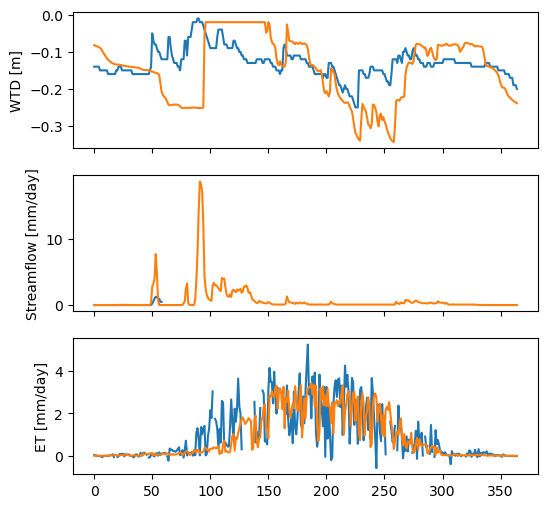

In [51]:
spday = 86400
fig, ax = plt.subplots(3, 1, figsize = (6, 6), 
                          sharex = True)
ax[0].plot(wte_calib.WTD)
ax[0].plot(-coldata.sel(column = 1).ZWT)
ax[0].set_ylabel('WTD [m]')
ax[1].plot(stream_calib.flow_mmday)
ax[1].plot(spday*data.QRUNOFF)
ax[1].set_ylabel('Streamflow [mm/day]')
ax[2].plot(flux_calib.OET)
ax[2].plot(spday*data.QVEGT)
ax[2].set_ylabel('ET [mm/day]')

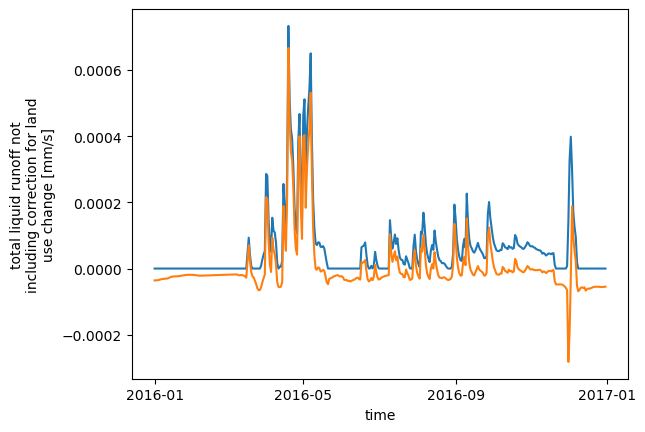

In [23]:
coldata.isel(column = 0).QOVER.plot(x = 'time')
coldata.isel(column = 0).QRUNOFF.plot(x = 'time')

In [24]:
data['ET'] = data.QVEGT + data.QSOIL
observedWTE = np.array(wte_calib.WTD)
modelWTE = -np.array(coldata.sel(column = 1).ZWT.values)
observedQ = np.array(stream_calib.flow_mmday)
modelQ = spday*np.array(data.QRUNOFF.values.ravel())
observedET = np.array(flux_calib.OET)
modelET = spday*np.array(data.ET.values.ravel())
#Compound Lee Choi Efficiency
print('--')
print('Efficiency Metrics')
print('LCE for WTE: ' + str(calcLCE(observedWTE, modelWTE)))
print('LCE for Q: ' + str(calcLCE(observedQ, modelQ)))
print('LCE for ET: ' + str(calcLCE(observedET, modelET)))
print('Compound LCE: ' + str(calcCompoundLCE(observedWTE, modelWTE, observedQ, modelQ, observedET, modelET)))

--
Efficiency Metrics


IndexError: boolean index did not match indexed array along dimension 0; dimension is 365 but corresponding boolean dimension is 366